In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
from gstools import SRF, Gaussian
from scipy.fftpack import dct, idct

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [3]:
# functions for downsample

def cartesian_mask(factor, PE_direction, distribution):
    acceleration, center_fraction = factor
    size = 320
    mask = np.zeros((size, size), dtype=bool)
    num_cols = size
    num_low_frequencies = round(num_cols * center_fraction)
       
    if (distribution == "uniform"):
        adjusted_accel = round((acceleration * (num_low_frequencies - num_cols)) / (num_low_frequencies * acceleration - num_cols))
        offset = np.random.randint(0, round(adjusted_accel))
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
    elif (distribution == "random"):
        prob = (num_cols / acceleration - num_low_frequencies) / (num_cols - num_low_frequencies)
        accel_samples = np.random.uniform(size=num_cols) < prob
    
    if (PE_direction == "LR"):
        mask[:, round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2)] = True
        mask[:, accel_samples] = True
    elif (PE_direction == "AP"):
        mask[round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2), :] = True
        mask[accel_samples, :] = True
 
    return mask

In [4]:
# functions for motion

def c2h(X):
    # convert cartesian to homogeneous coordinates
    
    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # convert a 2D transformation matrix and 2D translation vector to homogeneous transformation matrix

    T1 = np.concatenate((T, t[:,None]), axis=1)
    n = np.zeros([1, T1.shape[1]])
    n[-1,-1] = 1
    Th = np.concatenate((T1, n), axis=0)
    
    return Th

def rotate(phi):
    # create a 2D rotation matrix
    
    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(image, Th):
    # image transformation by inverse mapping

    # spatial coordinates of the transformed image
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    # perform inverse coordinates mapping
    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    image_t = ndimage.map_coordinates(image, [Xt[1,:], Xt[0,:]], order=3, mode='constant', cval=0.0).reshape(image.shape)

    return image_t

def combining_transforms(image, ang_deg, trans_x, trans_y):

    # rotation around the image center
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(np.eye(2), np.array([int(image.shape[1]/2), int(image.shape[0]/2)]))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(np.eye(2), np.array([-int(image.shape[1]/2), -int(image.shape[0]/2)]))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(np.eye(2), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    image_t = image_transform(image, T_tot)
    
    return image_t

def rigid_motion(image, pe_direction, n_movements, ang_std, trans_std):
    # normalize the image from 0 to 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # locations of the movements
    if (pe_direction == "LR"):
        grid_size = image.shape[1]
    elif (pe_direction == "AP"):
        grid_size = image.shape[0]
    locs = np.sort(np.append(np.random.permutation(grid_size)[:(2*n_movements)], (0, grid_size)))

    # rotation and translation parameters
    ang = np.random.normal(0, ang_std, n_movements)
    trans_x = np.random.normal(0, trans_std, n_movements)
    trans_y = np.random.normal(0, trans_std, n_movements)

    # combine kspaces
    kspace = transform_image_to_kspace(image)
    for i in range(n_movements):
        img_i = combining_transforms(image, sum(ang[:(i+1)]), sum(trans_x[:(i+1)]), sum(trans_y[:(i+1)]))
        kspace_i = transform_image_to_kspace(img_i)
        if (pe_direction == "LR"):
            kspace[:, locs[2*i+1]:locs[2*i+2]] = kspace_i[:, locs[2*i+1]:locs[2*i+2]]
        elif (pe_direction == "AP"):
            kspace[locs[2*i+1]:locs[2*i+2], :] = kspace_i[locs[2*i+1]:locs[2*i+2], :]
    
    return kspace

def periodic_motion(kspace):
    x = np.linspace(-np.pi, np.pi, kspace.shape[1])
    y = np.linspace(-np.pi, np.pi, kspace.shape[0])
    kx, ky = np.meshgrid(x, y)

    # parameters
    alpha = np.random.uniform(0.1, 5) # respiratory frequency
    delta = np.random.uniform(0, 20) # shift along PE direction
    beta = np.random.uniform(0, np.pi/4) # phase
    ky0 = np.random.uniform(np.pi/10, np.pi/2) # center K-space lines without phase shift errors
    
    # phase error outside of center
    phase_error = ky*delta*np.sin(alpha*ky + beta)
    
    # no motion in the center of k-space
    phase_error[abs(ky) < ky0] = 0

    # add phase error to k-space
    kspace = kspace*np.exp(-1j*phase_error)

    return kspace

In [5]:
# functions for bias

# 2D discrete cosine transform
def dct2(grid):   
    # discrete cosine transform
    M = grid.shape[0]
    N = grid.shape[1]
    a = np.empty([M,M],float)
    b = np.empty([M,M],float)
    for i in range(M):
        a[i,:] = dct(grid[i,:], norm='ortho')
    for j in range(N):
        b[:,j] = dct(a[:,j], norm='ortho')
    
    # keep essential DCT coefficients
    b = b[:M, :N]
    
    # inverse discrete cosine transform
    m = b.shape[0]
    n = b.shape[1]
    M = 320
    N = 320
    a = np.empty([m,N],float)
    grid = np.empty([M,N],float)
    for i in range(m):
        a[i,:] = idct(b[i,:], n=M, norm='ortho')
    for j in range(N):
        grid[:,j] = idct(a[:,j], n=N, norm='ortho')
        
    return grid

def GetFields(image):    
    down_size = np.int32(np.divide(image.shape, 10))
    x = np.arange(down_size[0])
    y = np.arange(down_size[1])
    
    len_scale = np.random.uniform(10, 50)
    model = Gaussian(dim=2, var=50, len_scale=len_scale)

    srf = SRF(model)

    grid_z = srf((x, y), mesh_type='structured')
    grid_z = dct2(grid_z)
    
    bias_rng = np.random.uniform(0.20, 1.00)
    grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()),
                       (1 - bias_rng / 2, 1 + bias_rng / 2))
    
    return grid_z

In [6]:
# corrupt function

def corrupt(image, case):
    import random
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        signal_to_noise = np.random.uniform(0, 10)
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "downsample":
        mask = cartesian_mask(random.choice([(2, 0.16), (3, 0.12), (4, 0.08)]), random.choice(["LR", "AP"]), random.choice(["uniform", "random"]))  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "motion":
        motion_type = random.choice(["rigid", "periodic"])
        if (motion_type == "rigid"):
            n_movements = np.random.randint(1, 6)
            ang_std = 0.6
            trans_std = 1.1
            pe_direction = random.choice(["LR", "AP"])
            kspace = rigid_motion(image, pe_direction, n_movements, ang_std, trans_std)
        elif (motion_type == "periodic"):
            kspace = periodic_motion(kspace)
            
    elif case == "bias":
        bias = GetFields(image)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

(-0.5, 319.5, 319.5, -0.5)

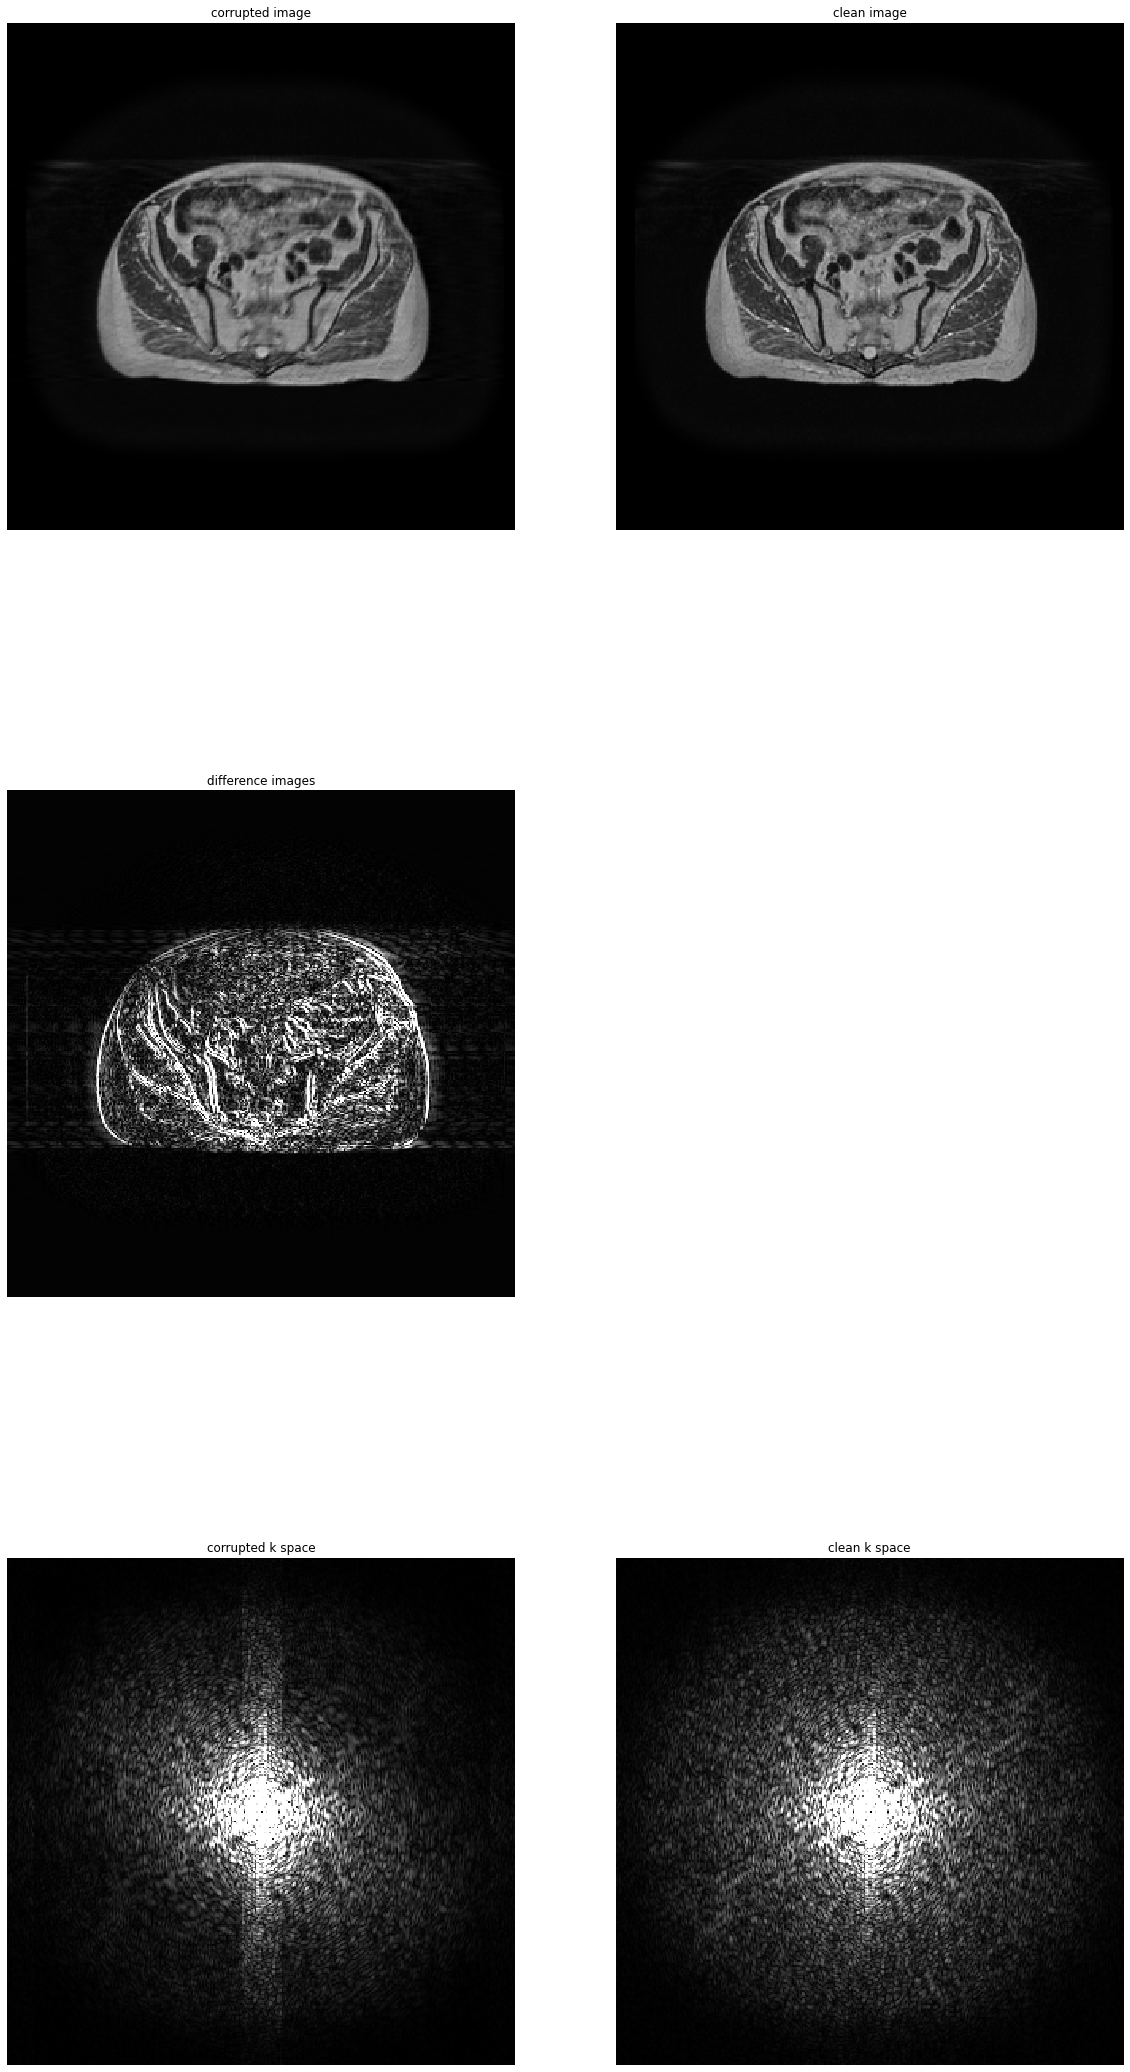

In [20]:
# plotting

img = corrupt(image, "motion")

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [8]:
print(np.min(image), np.mean(image), np.std(image), np.max(image))
print(np.min(img), np.mean(img), np.std(img), np.max(img))

-1.0081959379811776 0.0 0.9999999999999998 4.5807967981017566
-1.4790307183623241 -8.881784197001253e-18 1.0 3.9607453474770744


In [9]:
from sklearn.metrics import mean_squared_error
mean_squared_error(image, img)

0.15066603814775292

In [10]:
# the artefacts should be well-balanced in terms of MSE

import os
from sklearn.metrics import mean_squared_error

images_path_list = []
main_path_brain = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM'
main_path_pelvis = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis2'
#main_path = r'C:\from SSD\fastMRI_brain_DICOM'
#main_path = r'D:\Pelvis_2.2'

folders_brain = os.listdir(main_path_brain)
folders_pelvis = os.listdir(main_path_pelvis)

for folder in folders_brain:
    folder_path = main_path_brain + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
for folder in folders_pelvis:
    folder_path = main_path_pelvis + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
print(len(images_path_list))

488


In [11]:
error_motion_image_total = []

#for number in batch:
#batch = np.random.randint(0, len(images_path_list), 1000)
#batch = np.arange(len(images_path_list))
#np.random.shuffle(batch)
#batch = batch[:10000]


progress = np.linspace(0, len(images_path_list), 100, dtype=int)
#progress = np.linspace(0, len(batch), 100, dtype=int)
i = 0
j = 0

import time 
start = time.time()

for image_path in images_path_list:
#for number in batch: 
    #image_path = images_path_list[number]
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    i += 1
    if i in progress:
        j += 1
        print(j)
    
    if np.max(image) - np.min(image) > 1e-5:
        for i in range(1):
            image = (image - np.mean(image)) / np.std(image)

            img_motion = corrupt(image, "motion")
            error_motion_image = mean_squared_error(image, img_motion)
            error_motion_image_total.append(error_motion_image)

finish = time.time()
print('duration in minutes: {}'.format((finish-start)/60))

duration in minutes: 0.9642048756281535


In [12]:
print(np.mean(error_motion_image_total), np.std(error_motion_image_total))

0.05463477663308794 0.06627303738092462


In [13]:
# 370490 brain images and 49125 pelvic images